# Training and visualizing the Diffusion model

This notebook trains a diffusion model using visuo-tactile information from a soft-bubble sensor. The implementation is from Hugginface and can be found at [link](https://huggingface.co/blog/annotated-diffusion).

In the directory *model* you can find all the different files with the code use in this notebook. I'll try to explain each step taken as we move forward.

Fisrt, lets setup the enviroment so that we can edit .py files, and re-import them into the notebook.

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We now import some usefull libraries:

In [7]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

## Parts of a Diffusion model:
- Initial distribution: q(x_0) from real data.
- Target distribution: Pure gaussian noise. N(0,sigma*I)
- Beta/variance schedule.
- U-net block.
- Attention
- 
-

Let's define first the beta schedule for a toy example. The example uses a linear scheduler (not recommended) and a timestep of 300.

In [8]:
from model.diffusion.beta_schedule import linear_beta_schedule, quadratic_beta_schedule, cosine_beta_schedule, sigmoid_beta_schedule


timesteps = 500

# define beta schedule
betas = quadratic_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

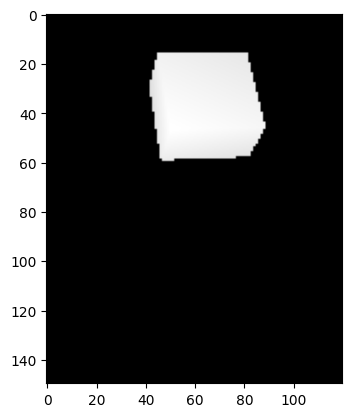

In [9]:
dataset_dir = "./data/datasets/toy_dataset/training/"
img_dir = "scene_test/depth_gt/depth_data/depth_000111.npy"

image = np.load(dataset_dir + img_dir)

plt.imshow(image, cmap='gray_r')
plt.show()

In [10]:
from torchvision.transforms import Compose, ToTensor, Lambda, Resize


bg_value = np.max(image)
img_shape = image.shape[:2]
img_size = 48 #np.max(img_shape) - 2

transform = Compose([
    ToTensor(), # turn into torch Tensor of shape CHW
    Lambda(lambda t: (t / bg_value * 2) - 1),
    Resize((img_size, img_size))
])

reverse_transform = Compose([
    Resize(img_shape),
    Lambda(lambda t: (t + 1) * bg_value / 2),
    Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    Lambda(lambda t: t.detach().cpu().numpy())
])

x_start = transform(image).unsqueeze(0)
x_reversed = reverse_transform(x_start.squeeze(0))

max_value = torch.max(x_start)
min_value = torch.min(x_start)
print(x_start.shape)
print(x_reversed.shape)
print(min_value.item(), max_value.item())

torch.Size([1, 1, 48, 48])
(150, 120, 1)
-0.04449557885527611 1.0000001192092896


In [11]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze(0))

  return noisy_image

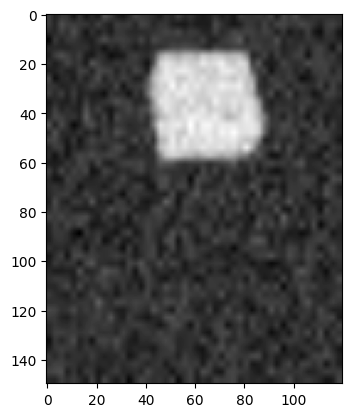

In [12]:
t = torch.tensor([40])

noise_img = get_noisy_image(x_start, t)

plt.imshow(noise_img, cmap='gray_r')
plt.show()

In [13]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(img, cmap='gray_r')
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [14]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 200, 300, 400, 499]])

In [15]:
def p_losses(denoise_model, x_start, t, condition=None, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, x_self_cond=condition)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [16]:
from data.dataloader.dataloader import BubbleDataset


training_dir = "./data/datasets/toy_dataset/training/processed_data/training/"
validation_dir = "./data/datasets/toy_dataset/training/processed_data/training/"

train_dataset = BubbleDataset(training_dir, transform)
val_dataset = BubbleDataset(validation_dir, transform)

print(f"Trainig dataset len: {train_dataset.__len__()} image pairs")
print(f"Validation dataset len: {val_dataset.__len__()} image pairs")

Trainig dataset len: 10000 image pairs
Validation dataset len: 10000 image pairs


In [17]:
from torch.utils.data import DataLoader


channels = 1
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [18]:
batch = next(iter(train_dataloader))
print(f"Batch type: {type(batch)}, length: {len(batch)}")

Batch type: <class 'dict'>, length: 11


In [19]:
@torch.no_grad
def p_sample(model, x, t, t_index, condition=None):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, x_self_cond=condition) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad
def p_sample_loop(model, shape, condition=None):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        #if i == timesteps - 1:
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, condition=condition)
        #else:
        #    img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, condition=None)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad
def sample(model, img_size, condition=None, batch_size=16, channels=1):
    return p_sample_loop(model, shape=(batch_size, channels, img_size, img_size), condition=condition)

In [20]:


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


## Training: from pretty image to soft-bubble
Let's train from a pretty depth image to a Soft-bubble sensor output first. We do the following three steps:
1) Create an instance of the model.
2) Train the model using the training dataset.
3) Tune hyperpatameter using the validation dataset.

In [21]:
results_folder = "./results/pretty2soft/"
subdirectories = ["imgs", "model"]
for directory in subdirectories:
    folder = Path(results_folder + directory)
    folder.mkdir(parents=True, exist_ok = True)

In [22]:
from torch.optim import Adam
from model.diffusion.u_net import Unet


device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)

model_pretty_to_sb = Unet(
    dim=img_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    self_condition=True
)
model_pretty_to_sb.to(device)

optimizer = Adam(model_pretty_to_sb.parameters(), lr=1e-4)

device:  cuda


In [23]:
epochs = 10
loss_type = "huber"

iteration = 0
iteration_data = []
loss_data = []

for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
      optimizer.zero_grad()

      batch_size = batch["depth_gt"].shape[0]
      depth_gt = batch["depth_gt"].to(device)
      depth_img = batch["depth_img"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model_pretty_to_sb, depth_img, t, depth_gt, loss_type=loss_type)

      if step % 20 == 0:
        iteration_data.append(iteration)
        loss_data.append(loss.item())

      loss.backward()
      optimizer.step()
      iteration += 1
    print(f"Epoch {epoch} done, with loss {loss}")

torch.save(model_pretty_to_sb.state_dict(), results_folder + "model/model_params.pt")

Epoch 0 done, with loss 0.005871366243809462
Epoch 1 done, with loss 0.005763949826359749
Epoch 2 done, with loss 0.0044744983315467834
Epoch 3 done, with loss 0.0016186513239517808
Epoch 4 done, with loss 0.0019922300707548857
Epoch 5 done, with loss 0.0010648297611624002
Epoch 6 done, with loss 0.0018887330079451203
Epoch 7 done, with loss 0.0021033845841884613
Epoch 8 done, with loss 0.0011131258215755224
Epoch 9 done, with loss 0.00263370294123888


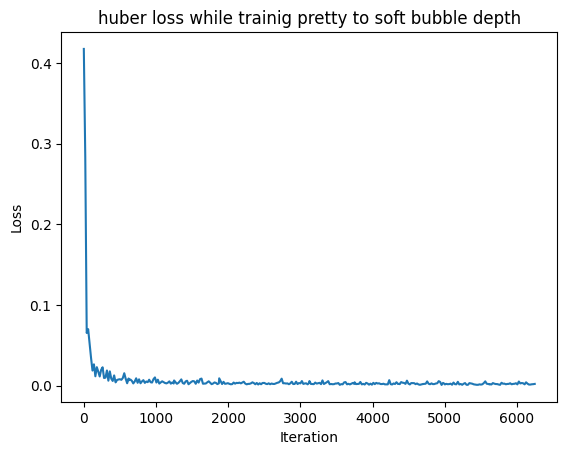

In [24]:
plt.figure()
plt.title(f"{loss_type} loss while trainig pretty to soft bubble depth")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(iteration_data, loss_data)

In [25]:
# sample images
batch = next(iter(val_dataloader))
batch_size = batch["depth_gt"].shape[0]
depth_gt = batch["depth_gt"].to(device)
depth_img = batch["depth_img"].to(device)
samples1 = sample(model_pretty_to_sb, img_size=img_size, batch_size=batch_size, channels=channels, condition=depth_gt)

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

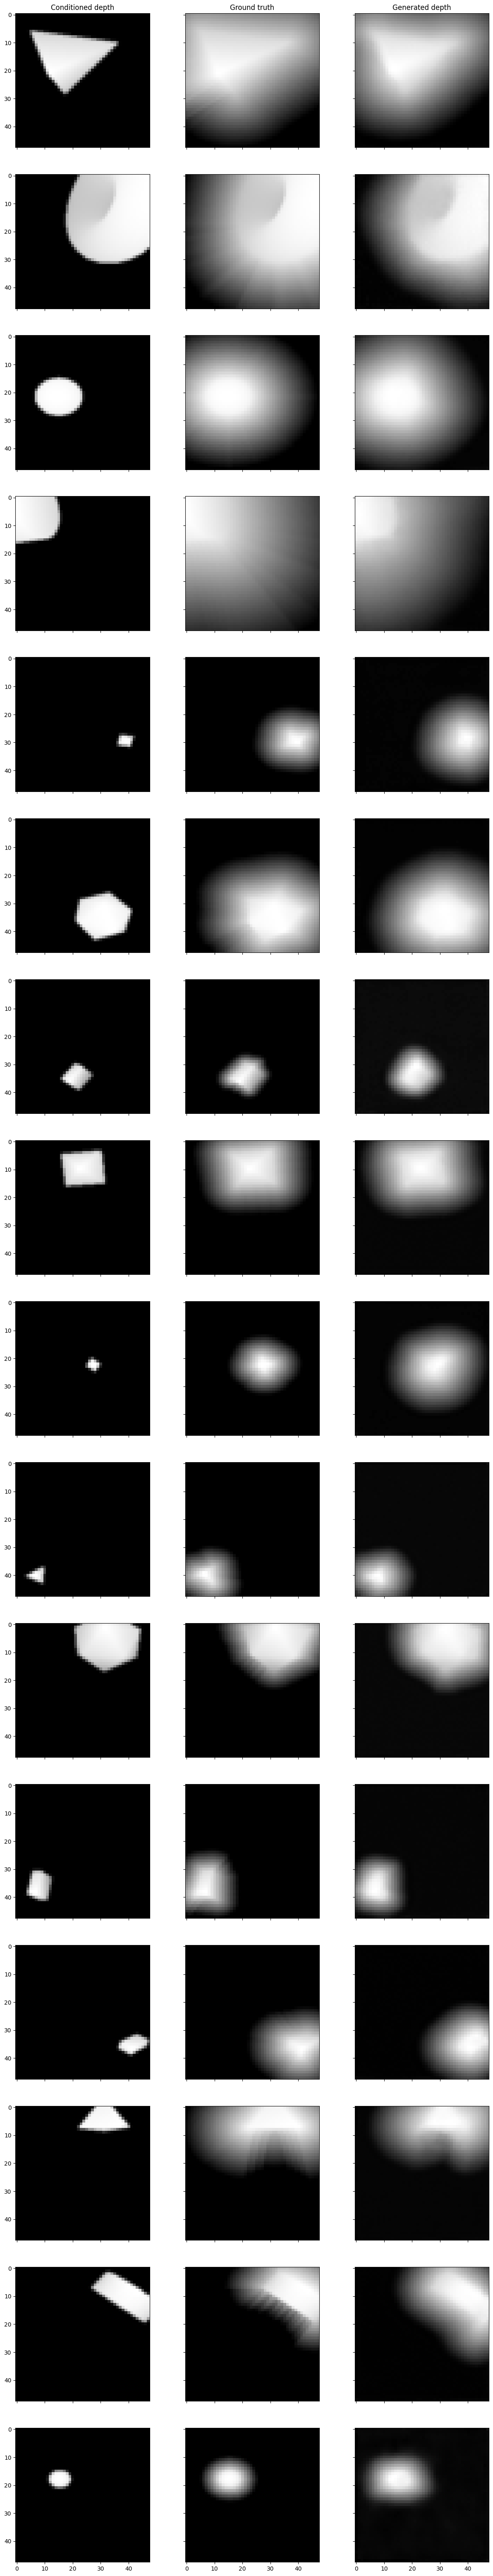

In [26]:
# from a batch show the generated results
fig, axs = plt.subplots(batch_size, 3, sharex=True, sharey=True, figsize=(15, 5*batch_size))
cols = ["Conditioned depth", "Ground truth", "Generated depth"]
for ax, col in zip(axs[0], cols):
    ax.set_title(col)
for i in range(batch_size):
    condition = depth_gt[i].reshape(img_size, img_size, channels).cpu().numpy()
    gt = depth_img[i].reshape(img_size, img_size, channels).cpu().numpy()
    generated = samples1[-1][i].reshape(img_size, img_size, channels)
    axs[i, 0].imshow(condition, cmap="gray_r")
    axs[i, 1].imshow(gt, cmap="gray_r")
    axs[i, 2].imshow(generated, cmap="gray_r")
plt.savefig(results_folder + "imgs/validation_visualization.png")

In [27]:
bg_value1 = np.max(condition)
bg_value2 = np.max(gt)
bg_value3 = np.max(generated)
print(bg_value1, bg_value2, bg_value3)

1.0000001 1.0000001 0.97918224


## Training: from soft-bubble depth image to pretty depth.
Now let's train from a Soft-bubble sensor output to a pretty depth image. We follow the same three steps as above:
1) Create an instance of the model.
2) Train the model using the training dataset.
3) Tune hyperpatameter using the validation dataset.

In [28]:
results_folder = "./results/soft2pretty/"
subdirectories = ["imgs", "model"]
for directory in subdirectories:
    folder = Path(results_folder + directory)
    folder.mkdir(parents=True, exist_ok = True)

In [29]:
from torch.optim import Adam
from model.diffusion.u_net import Unet


device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)

model_sb_to_pretty = Unet(
    dim=img_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    self_condition=True
)
model_sb_to_pretty.to(device)

optimizer = Adam(model_sb_to_pretty.parameters(), lr=1e-4)

device:  cuda


In [30]:
epochs = 10
loss_type = "huber"

iteration = 0
iteration_data = []
loss_data = []

for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
      optimizer.zero_grad()

      batch_size = batch["depth_gt"].shape[0]
      depth_gt = batch["depth_gt"].to(device)
      depth_img = batch["depth_img"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model_sb_to_pretty, depth_gt, t, depth_img, loss_type=loss_type)

      if step % 20 == 0:
        iteration_data.append(iteration)
        loss_data.append(loss.item())

      loss.backward()
      optimizer.step()
      iteration += 1
    print(f"Epoch {epoch} done, with loss {loss}")

torch.save(model_sb_to_pretty.state_dict(), results_folder + "model/model_params.pt")

Epoch 0 done, with loss 0.003972847014665604
Epoch 1 done, with loss 0.0035029479768127203
Epoch 2 done, with loss 0.0023761955089867115
Epoch 3 done, with loss 0.0037858481518924236
Epoch 4 done, with loss 0.0012500338489189744
Epoch 5 done, with loss 0.003650880651548505
Epoch 6 done, with loss 0.00414283899590373
Epoch 7 done, with loss 0.001592977438122034
Epoch 8 done, with loss 0.0009371046326123178
Epoch 9 done, with loss 0.0009249299764633179


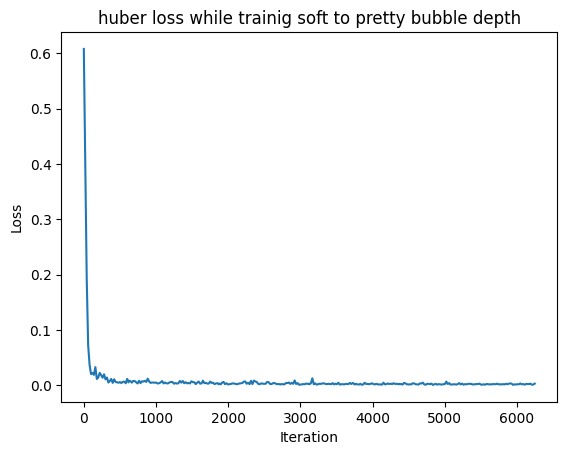

In [31]:
plt.figure()
plt.title(f"{loss_type} loss while trainig soft to pretty bubble depth")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(iteration_data, loss_data)

In [32]:
# sample images
batch = next(iter(val_dataloader))
batch_size = batch["depth_gt"].shape[0]
depth_gt = batch["depth_gt"].to(device)
depth_img = batch["depth_img"].to(device)
samples2 = sample(model_sb_to_pretty, img_size=img_size, batch_size=batch_size, channels=channels, condition=depth_img)

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

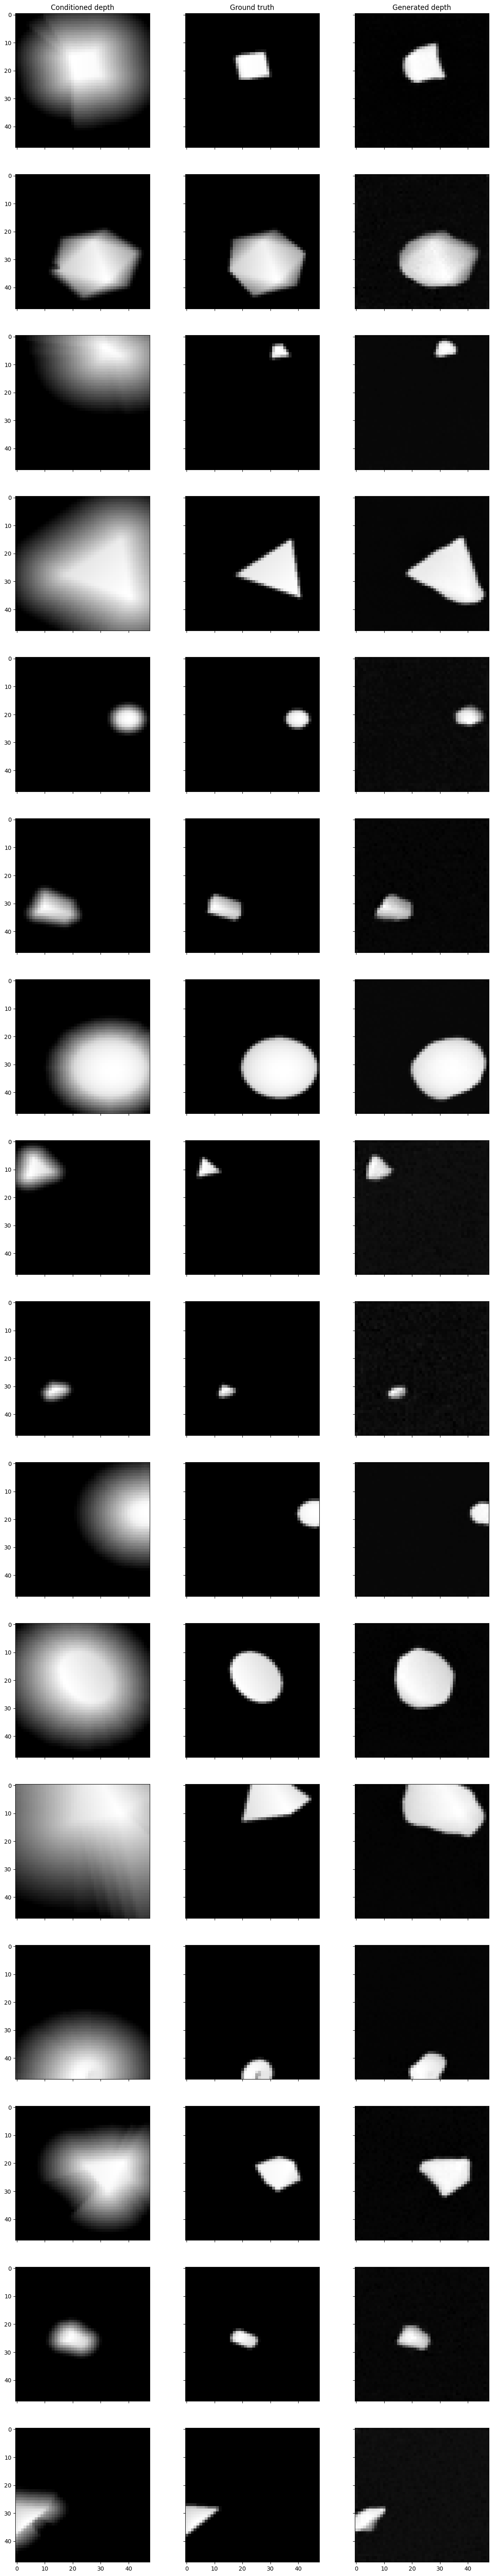

In [33]:
# from a batch show the generated results
fig, axs = plt.subplots(batch_size, 3, sharex=True, sharey=True, figsize=(15, 5 * batch_size))
cols = ["Conditioned depth", "Ground truth", "Generated depth"]
for ax, col in zip(axs[0], cols):
    ax.set_title(col)
for i in range(batch_size):
    condition = depth_img[i].reshape(img_size, img_size, channels).cpu().numpy()
    gt = depth_gt[i].reshape(img_size, img_size, channels).cpu().numpy()
    generated = samples2[-1][i].reshape(img_size, img_size, channels)
    axs[i, 0].imshow(condition, cmap="gray_r")
    axs[i, 1].imshow(gt, cmap="gray_r")
    axs[i, 2].imshow(generated, cmap="gray_r")
plt.savefig(results_folder + "imgs/validation_visualization.png")